In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()
key = os.getenv("OPENAI_API_KEY")
print("Key loaded:", bool(key))
print("Key prefix:", key[:5] if key else None)

Key loaded: True
Key prefix: sk-pr


In [3]:
from langchain_openai import OpenAIEmbeddings

emb = OpenAIEmbeddings(model="text-embedding-3-small")
vec = emb.embed_query("hello from agentic rag")
print("Embedding length:", len(vec))
print("First 5 dims:", vec[:5])


Embedding length: 1536
First 5 dims: [-0.004728053230792284, -0.01015774067491293, -0.04726458713412285, 0.054536063224077225, 0.013227387331426144]


Load web pages

In [4]:
URLS = [
    "https://python.langchain.com/docs/introduction/",
    "https://langchain-ai.github.io/langgraph/",
]

from langchain_community.document_loaders import WebBaseLoader

docs = []
for url in URLS:
    docs.extend(WebBaseLoader(url).load())

print("Docs loaded:", len(docs))
print("First doc metadata:", docs[0].metadata)
print("First doc preview:\n", docs[0].page_content[:500])


USER_AGENT environment variable not set, consider setting it to identify your requests.


Docs loaded: 2
First doc metadata: {'source': 'https://python.langchain.com/docs/introduction/', 'title': 'LangChain overview - Docs by LangChain', 'description': 'LangChain is an open source framework with a pre-built agent architecture and integrations for any model or tool — so you can build agents that adapt as fast as the ecosystem evolves', 'language': 'en'}
First doc preview:
 LangChain overview - Docs by LangChainSkip to main contentDocs by LangChain home pageLangChain + LangGraphSearch...⌘KAsk AIGitHubTry LangSmithTry LangSmithSearch...NavigationLangChain overviewLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonOverviewGet startedInstallQuickstartChangelogPhilosophyCore componentsAgentsModelsMessagesToolsShort-term memoryStreamingStructured outputMiddlewareOverviewBuilt-in middlewareCustom middlewareAdvanced usageGuardrailsRuntimeContext engine


In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
chunks = splitter.split_documents(docs)

print("Chunks:", len(chunks))
print("Sample chunk:\n", chunks[0].page_content[:100])


Chunks: 8
Sample chunk:
 LangChain overview - Docs by LangChainSkip to main contentDocs by LangChain home pageLangChain + Lan


# Load vector index if it exists (fast, no re-embedding)
# Otherwise build once and persist to disk


In [34]:
import os
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

VECTOR_DIR = "faiss_index"
emb = OpenAIEmbeddings(model="text-embedding-3-small")

if os.path.exists(VECTOR_DIR):
    vectorstore = FAISS.load_local(VECTOR_DIR, emb, allow_dangerous_deserialization=True)
    print("Loaded FAISS index ✅")
else:
    vectorstore = FAISS.from_documents(chunks, emb)
    vectorstore.save_local(VECTOR_DIR)
    print("Built + Saved FAISS index ✅")

retriever = vectorstore.as_retriever(search_kwargs={"k": 4})


Loaded FAISS index ✅


In [28]:
from typing import TypedDict, List, Optional
from langgraph.graph import StateGraph, START,END

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

class State(TypedDict):
    question: str
    use_rag: bool
    contexts: List[str]
    answer: str
    sources: List[str]

def route(state: State) -> State:
    q = state["question"].lower()

    triggers = [
        "pdf", "summar", "summary", "summarize",
        "docs", "documentation", "doc",
        "web", "website", "url", "link",
        "article", "blog", "source", "from the page",
    ]

    use_rag = any(t in q for t in triggers)

    return {**state, "use_rag": use_rag, "contexts": [], "sources": []}

def retrieve(state: State) -> State:
    docs = retriever.invoke(state["question"])
    contexts = [" ".join(d.page_content.split()) for d in docs]
    sources = [d.metadata.get("source", "unknown") for d in docs]
    return {**state, "contexts": contexts, "sources": sources}

def rag_answer(state: State) -> State:
    context_text = "\n\n".join(state["contexts"][:4])
    prompt = f"""Answer using only the context. If missing, say "I don't know".

Context:
{context_text}

Q: {state["question"]}
A:"""
    resp = llm.invoke(prompt)
    ans = resp.content

    # add sources
    uniq = []
    for s in state["sources"]:
        if s not in uniq:
            uniq.append(s)
    ans += "\n\nSources:\n" + "\n".join(f"- {s}" for s in uniq[:4])

    return {**state, "answer": ans}

def direct_answer(state: State) -> State:
    resp = llm.invoke(f"Answer concisely.\nQ: {state['question']}\nA:")
    return {**state, "answer": resp.content}



In [29]:
from langgraph.graph import StateGraph, END

graph = StateGraph(State)
graph.add_node("route", route)
graph.add_node("retrieve", retrieve)
graph.add_node("rag_answer", rag_answer)
graph.add_node("direct_answer", direct_answer)

graph.set_entry_point("route")

def route_next(state: State) -> str:
    return "retrieve" if state["use_rag"] else "direct_answer"

graph.add_conditional_edges(
    "route",
    route_next,
    {"retrieve": "retrieve", "direct_answer": "direct_answer"},
)

graph.add_edge("retrieve", "rag_answer")
graph.add_edge("rag_answer", END)
graph.add_edge("direct_answer", END)

app = graph.compile()
print("Router Agentic RAG ready ✅")


Router Agentic RAG ready ✅


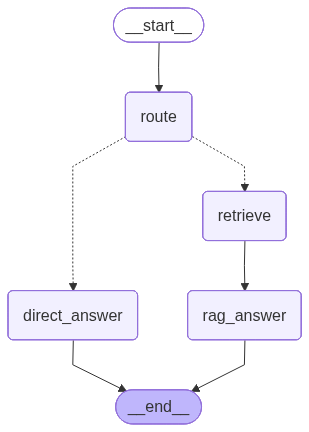

In [30]:
app 

TEST 1

In [31]:
res = app.invoke({"question": "Explain what an embedding is in simple words."})
print("use_rag:", res["use_rag"])
print(res["answer"][:600])


use_rag: False
An embedding is a way to represent items, like words or images, as points in a high-dimensional space, allowing similar items to be closer together. This helps computers understand and process them better.


TEST 2

In [32]:
res = app.invoke({"question": "Summarize what LangGraph is, from the docs."})
print("use_rag:", res["use_rag"])
print(res["answer"][:600])

use_rag: True
LangGraph is a low-level agent orchestration framework and runtime designed for advanced needs that require a combination of deterministic and agentic workflows, heavy customization, and carefully controlled latency. It serves as the foundation for LangChain agents, providing features like durable execution, streaming, human-in-the-loop, and persistence.

Sources:
- https://langchain-ai.github.io/langgraph/
- https://python.langchain.com/docs/introduction/
